In [2]:
import torch
from modules.utils import *
import numpy as np
from modules.kan_model import DeepKAN, SiameseKAN
from modules.mlp_model import MLP, SiameseMLP
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import tensorboard
import pandas as pd
import anndata as ad
import scanpy as sc
import torch.optim as optim
import torch.nn.functional as F

In [118]:
# Synthetic data generation
def generate_synthetic_data(n_samples=1000):
    x = np.random.uniform(-1, 1, n_samples)
    y = np.random.uniform(-1, 1, n_samples)
    z = np.exp(np.sin(np.pi * x) + y**2)
    return torch.tensor(np.vstack([x, y]).T, dtype=torch.float32), torch.tensor(z, dtype=torch.float32)

X, y = generate_synthetic_data()

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [119]:
class SplineLinearLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_knots=5, spline_order=3,
                 noise_scale=0.1, base_scale=1.0, spline_scale=1.0,
                 activation=torch.nn.SiLU, grid_epsilon=0.02, grid_range=[-1, 1],
                 standalone_spline_scaling=True):
        super(SplineLinearLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_knots = num_knots
        self.spline_order = spline_order
        self.grid_epsilon = grid_epsilon
        self.grid_range = grid_range
        self.standalone_spline_scaling = standalone_spline_scaling

        self.knots = self._calculate_knots(grid_range, num_knots, spline_order)
        self.base_weights = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        self.spline_weights = torch.nn.Parameter(torch.Tensor(output_dim, input_dim, num_knots + spline_order))
        if standalone_spline_scaling:
            self.spline_scales = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))

        self.noise_scale = noise_scale
        self.base_scale = base_scale
        self.spline_scale = spline_scale
        self.activation = activation()

        self._initialize_parameters()

    def _initialize_parameters(self):
        torch.nn.init.xavier_uniform_(self.base_weights, gain=torch.sqrt(torch.tensor(2.0)))
        noise = torch.rand(self.num_knots + 1, self.input_dim, self.output_dim) - 0.5
        self.spline_weights.data.copy_(self.spline_scale * self._initialize_spline_weights(noise))
        if self.standalone_spline_scaling:
            torch.nn.init.xavier_uniform_(self.spline_scales, gain=torch.sqrt(torch.tensor(2.0)))

    def _calculate_knots(self, grid_range, num_knots, spline_order):
        h = (grid_range[1] - grid_range[0]) / num_knots
        knots = torch.arange(-spline_order, num_knots + spline_order + 1) * h + grid_range[0]
        return knots.expand(self.input_dim, -1).contiguous()

    def _initialize_spline_weights(self, noise):
        return self._fit_curve_to_coefficients(self.knots.T[self.spline_order : -self.spline_order], noise)

    def _compute_b_splines(self, x):
        self.knots = self.knots.to(x.device)
        x = x.unsqueeze(-1)
        bases = ((x >= self.knots[:, :-1]) & (x < self.knots[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - self.knots[:, : -(k + 1)]) / (self.knots[:, k:-1] - self.knots[:, : -(k + 1)]) * bases[:, :, :-1] +
                     (self.knots[:, k + 1 :] - x) / (self.knots[:, k + 1 :] - self.knots[:, 1:(-k)]) * bases[:, :, 1:])
        return bases.contiguous()

    def _fit_curve_to_coefficients(self, x, y):
        A = self._compute_b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    @property
    def _scaled_spline_weights(self):
        return self.spline_weights * (self.spline_scales.unsqueeze(-1) if self.standalone_spline_scaling else 1.0)

    def forward(self, x):
        base_output = F.linear(self.activation(x), self.base_weights)
        spline_output = F.linear(self._compute_b_splines(x).view(x.size(0), -1),
                                 self._scaled_spline_weights.view(self.output_dim, -1))
        return base_output + spline_output

    def _regularization_loss(self, regularize_activation, regularize_entropy):
        # Calculate L1 norm of activation functions
        l1_norm = torch.mean(torch.abs(self.base_weights)) + torch.mean(torch.abs(self.spline_weights))
        
        # Calculate entropy regularization
        activation_norms = torch.abs(self.base_weights) + torch.abs(self.spline_weights).sum(dim=2)
        total_norm = torch.sum(activation_norms)
        normalized_activation_norms = activation_norms / total_norm
        entropy = -torch.sum(normalized_activation_norms * torch.log(normalized_activation_norms + 1e-8))
        
        # Combine the regularization terms
        regularization_loss = regularize_activation * l1_norm + regularize_entropy * entropy
        return regularization_loss

    @torch.no_grad()
    def prune_weights(self, threshold=0.01):
        mask_base = torch.abs(self.base_weights) > threshold
        mask_spline = torch.abs(self.spline_weights) > threshold
        self.base_weights.data *= mask_base
        self.spline_weights.data *= mask_spline

    @torch.no_grad()
    def _update_knots(self, x, margin=0.01):
        batch = x.size(0)
        splines = self._compute_b_splines(x).permute(1, 0, 2)
        orig_coeff = self._scaled_spline_weights.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        adaptive_knots = x_sorted[torch.linspace(0, batch - 1, self.num_knots + 1, dtype=torch.int64, device=x.device)]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.num_knots
        uniform_knots = torch.arange(self.num_knots + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin

        knots = self.grid_epsilon * uniform_knots + (1 - self.grid_epsilon) * adaptive_knots
        knots = torch.cat([
            knots[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
            knots,
            knots[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
        ], dim=0)

        self.knots.copy_(knots.T)
        self.spline_weights.data.copy_(self._fit_curve_to_coefficients(x, unreduced_spline_output))

class DeepKAN(torch.nn.Module):
    def __init__(self, input_dim, hidden_layers, num_knots=5, spline_order=3,
                 noise_scale=0.1, base_scale=1.0, spline_scale=1.0,
                 activation=torch.nn.SiLU, grid_epsilon=0.02, grid_range=[-1, 1]):
        super(DeepKAN, self).__init__()
        layers = [input_dim] + hidden_layers
        self.layers = torch.nn.ModuleList()
        for in_dim, out_dim in zip(layers, layers[1:]):
            self.layers.append(SplineLinearLayer(in_dim, out_dim, num_knots, spline_order,
                                                 noise_scale, base_scale, spline_scale,
                                                 activation, grid_epsilon, grid_range))

    def forward(self, x, update_knots=False):
        for layer in self.layers:
            if update_knots:
                layer._update_knots(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        total_regularization_loss = sum(layer._regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)
        return total_regularization_loss

    def prune_network(self, threshold=0.01):
        for layer in self.layers:
            layer.prune_weights(threshold)

In [120]:
# Define the DeepKAN model
input_dim = X_train.shape[1]
hidden_layers = [5, 2, 1]  # Example architecture
model = DeepKAN(input_dim, hidden_layers)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with sparsification
n_epochs = 1000
regularize_activation = 10
regularize_entropy = 10
l1_lambda = 0.1

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Add regularization loss
    reg_loss = model.regularization_loss(regularize_activation, regularize_entropy)
    total_loss = loss + l1_lambda * reg_loss
    
    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss.item():.4f}')

Epoch [100/1000], Loss: 9.6341
Epoch [200/1000], Loss: 8.7559
Epoch [300/1000], Loss: 8.1451
Epoch [400/1000], Loss: 7.5752
Epoch [500/1000], Loss: 6.9562
Epoch [600/1000], Loss: 6.4627
Epoch [700/1000], Loss: 5.9256
Epoch [800/1000], Loss: 5.3285
Epoch [900/1000], Loss: 4.6003
Epoch [1000/1000], Loss: 4.0142


In [121]:
# Prune the network
pruning_threshold = 0.01
model.prune_network(pruning_threshold)

In [122]:
mask = [(param != 0).float() for param in model.parameters()]

In [123]:
def apply_pruning_mask(model, mask):
    with torch.no_grad():
        for param, mask in zip(model.parameters(), mask):
            param.mul_(mask)

In [124]:
apply_pruning_mask(model, mask)

In [97]:
# Fine-tuning the model
for epoch in range(1000):  # Shorter fine-tuning period
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    apply_pruning_mask(model, mask)

    if (epoch + 1) % 20 == 0:
        print(f'Fine-tuning Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

Fine-tuning Epoch [20/100], Loss: 0.4139
Fine-tuning Epoch [40/100], Loss: 0.3900
Fine-tuning Epoch [60/100], Loss: 0.3760
Fine-tuning Epoch [80/100], Loss: 0.3658
Fine-tuning Epoch [100/100], Loss: 0.3574
Fine-tuning Epoch [120/100], Loss: 0.3499
Fine-tuning Epoch [140/100], Loss: 0.3428
Fine-tuning Epoch [160/100], Loss: 0.3359
Fine-tuning Epoch [180/100], Loss: 0.3290
Fine-tuning Epoch [200/100], Loss: 0.3223
Fine-tuning Epoch [220/100], Loss: 0.3158
Fine-tuning Epoch [240/100], Loss: 0.3095
Fine-tuning Epoch [260/100], Loss: 0.3033
Fine-tuning Epoch [280/100], Loss: 0.2972
Fine-tuning Epoch [300/100], Loss: 0.2910
Fine-tuning Epoch [320/100], Loss: 0.2847
Fine-tuning Epoch [340/100], Loss: 0.2784
Fine-tuning Epoch [360/100], Loss: 0.2722
Fine-tuning Epoch [380/100], Loss: 0.2662
Fine-tuning Epoch [400/100], Loss: 0.2604
Fine-tuning Epoch [420/100], Loss: 0.2549
Fine-tuning Epoch [440/100], Loss: 0.2496
Fine-tuning Epoch [460/100], Loss: 0.2447
Fine-tuning Epoch [480/100], Loss: 0.2

In [125]:
# Define the function to print the parameter values
def print_network_parameters(model):
    for i, layer in enumerate(model.layers):
        print(f"Layer {i + 1}:")
        print("Base Weights:")
        print(layer.base_weights.data)
        print("Spline Weights:")
        print(layer.spline_weights.data)
        if layer.standalone_spline_scaling:
            print("Spline Scales:")
            print(layer.spline_scales.data)
        print("-" * 50)

In [126]:
print_network_parameters(model)

Layer 1:
Base Weights:
tensor([[ 0.0000,  0.0000],
        [-0.0000, -0.2256],
        [ 0.3718,  0.3806],
        [-0.3444,  0.0000],
        [ 0.4266, -0.0000]])
Spline Weights:
tensor([[[-1.8003, -1.2844,  0.7186, -1.6928,  2.0538, -0.7702,  0.7364,
           1.4173],
         [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000]],

        [[-0.0000,  0.0000, -0.0000,  0.0000, -0.2799, -0.1272, -0.0000,
           0.0000],
         [ 0.0000, -0.0000, -0.7787,  0.1117, -0.0000, -0.3978, -0.0000,
          -0.0000]],

        [[ 0.0000,  0.0000, -0.0000, -0.0000,  0.2410,  0.0000, -0.0000,
           0.0000],
         [-0.0000, -0.0275, -0.1665,  0.0000, -0.0000,  0.0000, -0.7889,
          -0.0000]],

        [[-0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0545, -0.0126,
           0.0000],
         [ 0.0000, -0.0000,  0.0000, -0.0000, -0.0740,  0.0000, -0.0000,
          -0.0000]],

        [[ 0.0000, -0.0424,  0.0365,  0.2056, -0.3571, -1.3419,  0.6

In [113]:
outputs1, outputs2, targets1, targets2 = pickle.load(open('embed_kan_0_3_64_1.0.pth.pkl', 'rb'))

In [114]:
outputs1 = np.stack(outputs1)

In [115]:
outputs2 = np.stack(outputs2)

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


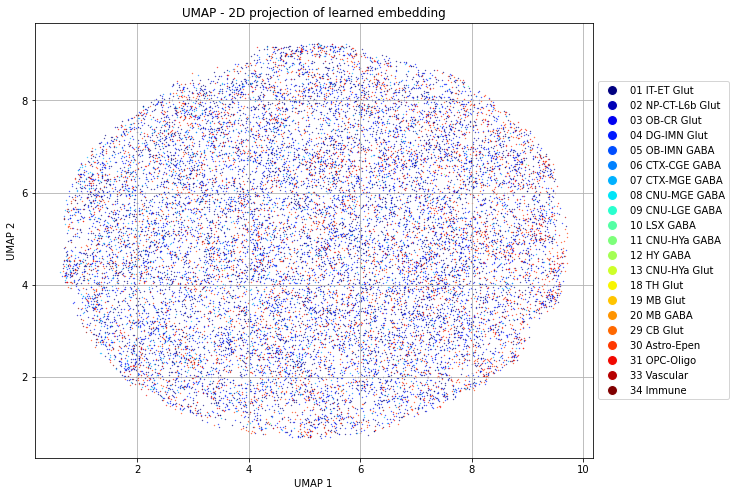

In [116]:
get_umap(outputs1, targets1, 'kan', 'whatev', mapping1)

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


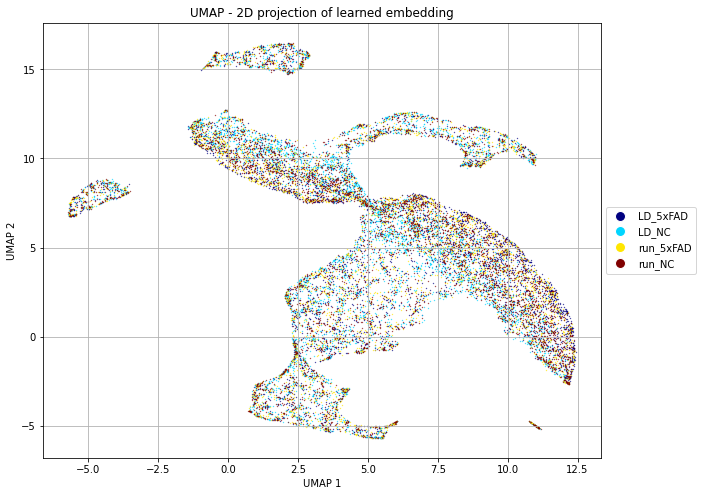

In [117]:
get_umap(outputs2, targets2, 'kan', 'whatev', mapping2)

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir=runs --port=6760